In [27]:
import pandas as pd
from patsy import dmatrices
import matplotlib.pyplot as plt
import math as m
import numpy as np
import seaborn as sns
import statsmodels as sm
import statsmodels.api as sma
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
sns.set(font_scale = 2.5)
plt.rcParams['figure.figsize'] = (12, 9)

In [29]:
def growth_rate_to_doubling_time(growth_rates):
    return np.sign(growth_rates) * (np.log(2) / (np.sign(growth_rates) * growth_rates))

def doubling_time_to_growth_rate(doubling_times):
    return np.sign(doubling_times) * ( np.log(2) / (np.sign(doubling_times) * doubling_times))

In [31]:
data = pd.read_excel("Data/Simulation Results/growth rates no test delays.xlsx", index_col = 0)
days_simulated = 25

In [33]:
data

,hazard_rate_scale,infection_reporting_prob,contact_tracing_success_prob,contact_trace_delay_par,global_contact_reduction,two_step_tracing,prob_has_trace_app,0,1,2,...,15,16,17,18,19,20,21,22,23,24
0,0.244234,0.4,0.941355,1.874370,0.289852,False,0.083327,5000,5018,5272,...,55508,62592,70068,78253,86829,95784,105277,114974,125267,135800
1,0.250799,0.5,0.919922,2.494220,0.364649,True,0.137455,5000,5012,5263,...,45153,50167,55406,60682,66219,71847,77549,83361,89293,95516
2,0.231106,0.2,0.740977,1.967681,0.577663,False,0.160811,5000,5008,5163,...,27174,29423,31792,34240,36737,39282,41917,44603,47389,50138
3,0.244234,0.4,0.731077,1.587389,0.263055,True,0.227969,5000,5015,5269,...,60478,68906,78165,88572,99773,111983,125030,139468,155178,172057
4,0.237670,0.3,0.789975,2.014826,0.737690,True,0.359516,5000,5000,5117,...,15970,16648,17276,17819,18345,18832,19296,19700,20104,20458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.250799,0.5,0.882274,1.713300,0.132286,False,0.398765,5000,5021,5340,...,77252,88751,101059,114515,129376,145151,162308,180697,200651,222210
96,0.231106,0.2,0.914077,2.495003,0.372532,True,0.451773,5000,5008,5247,...,48090,54233,60927,68178,76006,84321,93112,102553,112535,122965
97,0.224541,0.1,0.806315,1.845686,0.076995,True,0.148336,5000,5021,5311,...,101472,123502,149942,181525,219540,264489,317950,381577,457024,545564
98,0.250799,0.5,0.741664,2.227489,0.045821,False,0.447310,5000,5012,5340,...,98223,116403,137417,161601,189521,221390,258179,300216,347823,403067


In [35]:
infection_counts = [str(i) for i in range(days_simulated)]
infection_counts = data[infection_counts]

Text(0.5, 1.0, 'Total Infected')

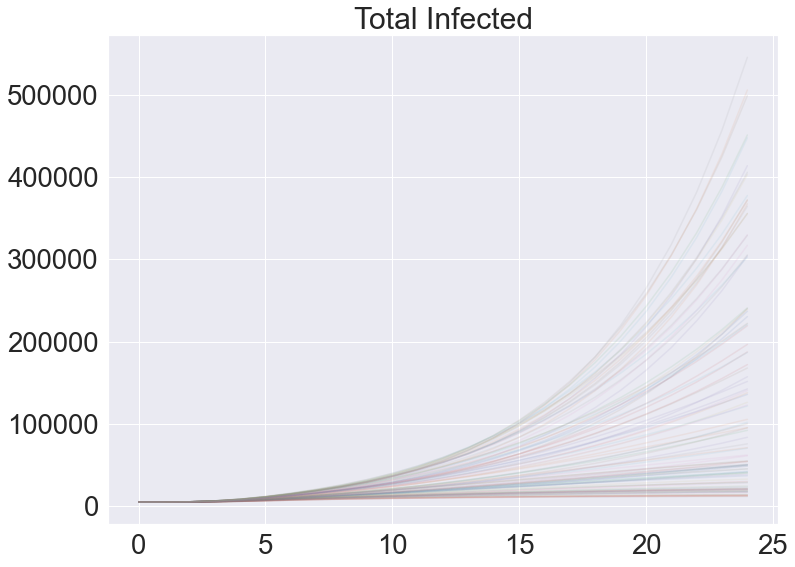

In [37]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_], alpha = 0.1)
plt.title("Total Infected")

Text(0.5, 1.0, '$log_2$(Total Infected)')

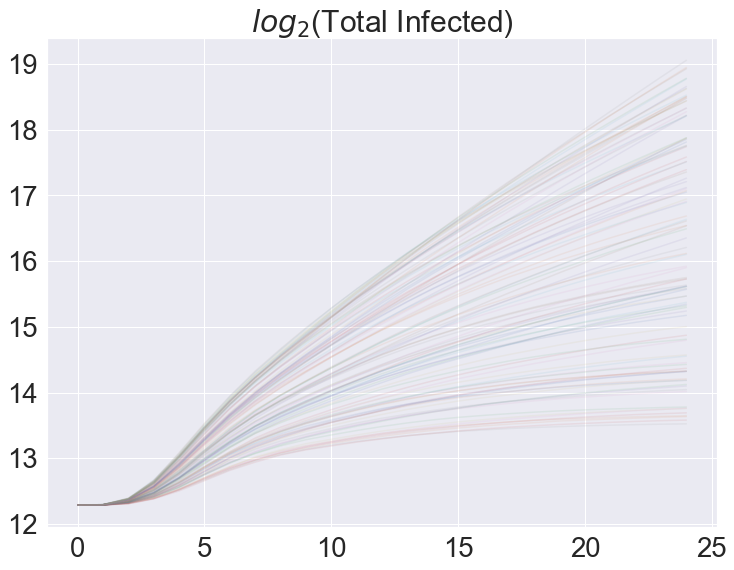

In [39]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_].apply(lambda x: np.log2(x)), alpha = 0.1)
plt.title("$log_2$(Total Infected)")

Text(0.5, 1.0, 'Infection Incidence')

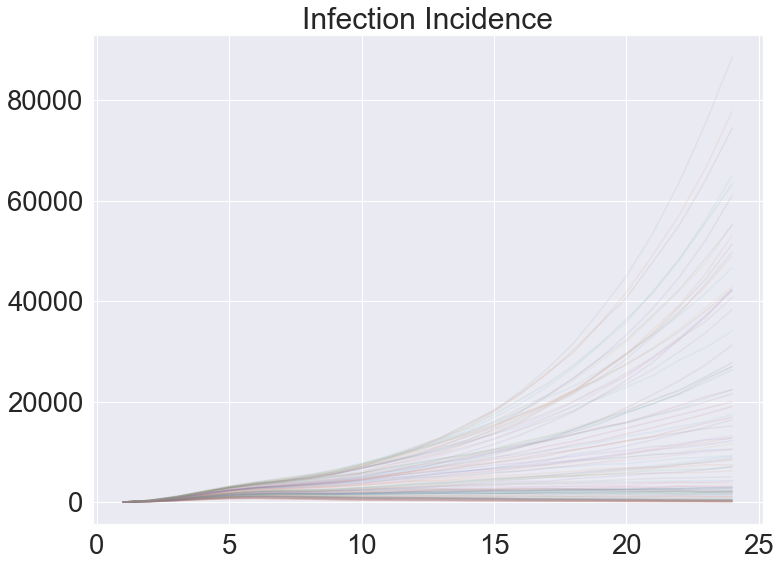

In [41]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1), alpha = 0.1)
plt.title("Infection Incidence")

Text(0.5, 1.0, 'Infection Incidence (10 epidemics)')

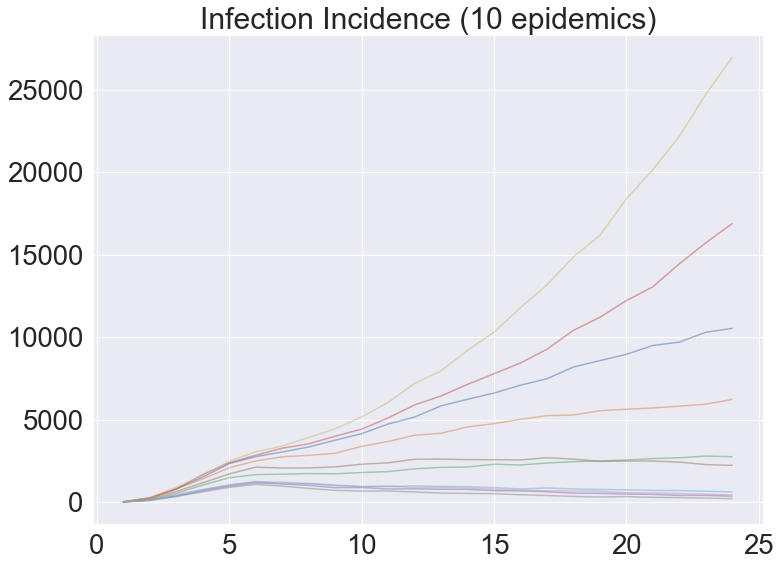

In [43]:
for _ in range(10):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1), alpha = 0.5)
plt.title("Infection Incidence (10 epidemics)")

Text(0.5, 1.0, '$Log_e$(Case Incidence) (14 epidemics)')

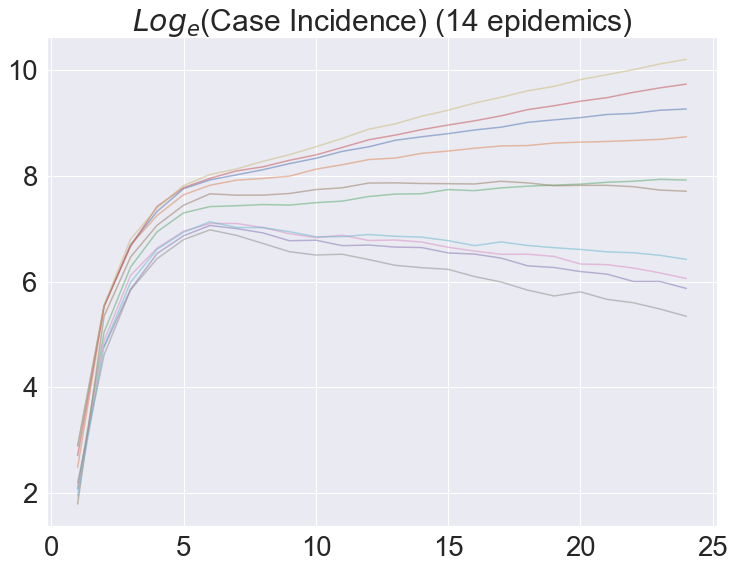

In [45]:
for _ in range(10):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1).apply(lambda x: np.log(x)), alpha = 0.5)
plt.title("$Log_e$(Case Incidence) (14 epidemics)")
#plt.savefig("Figures/Log_case_incidence.png")

We can see the variance begins to increase for the exponentially decaying epidemcis as they near 0. In order to get good estimation for the epidemics, we icnrease the starting number of infections. In this experiment, we start with 5000 infected, let the process run for 10 days, and then estimated the growth rate using days 10-30.

In [47]:
log_diff = infection_counts.iloc[_].diff(1).apply(lambda x: np.log(x))

data_set_up = {
    "log_case_incidence": log_diff[10:days_simulated],
    "time": list(range(10, days_simulated))
}
dataframe = pd.DataFrame(data_set_up)

                            OLS Regression Results                            
Dep. Variable:     log_case_incidence   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     187.9
Date:                Wed, 20 Jan 2021   Prob (F-statistic):           4.17e-09
Time:                        11:02:20   Log-Likelihood:                 28.407
No. Observations:                  15   AIC:                            -52.81
Df Residuals:                      13   BIC:                            -51.40
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2400      0.041    176.569      0.0

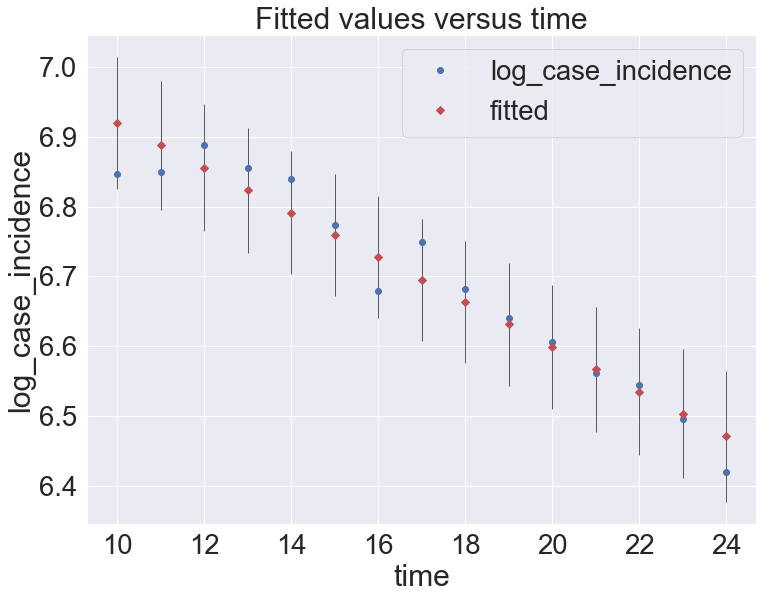

In [49]:
y, X = dmatrices('log_case_incidence ~ time', 
                 data = dataframe)
model = sma.OLS(y, X)
res = model.fit()
print(res.summary())
fig = sm.graphics.regressionplots.plot_fit(res, 1)
print(f"doublign time = {m.log(2)/res.params[1]}")

In [51]:
data_subset = infection_counts

In [ ]:
growth_rates = []
for _ in range(data_subset.shape[0]):
    print(f"current fit; {_}", end = "\r")
    
    log_diff = data_subset.iloc[_].diff(1).apply(lambda x: np.log(x))

    data_set_up = {
        "log_case_incidence": log_diff[10:25],
        "time": list(range(10, 25))
    }
    dataframe = pd.DataFrame(data_set_up)
    dataframe = pd.DataFrame(data_set_up)
    
    y, X = dmatrices('log_case_incidence ~ time', 
                     data = dataframe)
    model = sma.RLM(y, X)
    res = model.fit()
    growth_rates.append(res.params[1])

    if res.params[1] == -float("inf"):
        print(f"missing data in line {_}")

In [44]:
x = pd.Series(growth_rates) # 200 values
#x = x[x.between(x.quantile(.05), x.quantile(.95))] # without outliers

Text(0.5, 1.0, 'Distribution of Growth Rates')

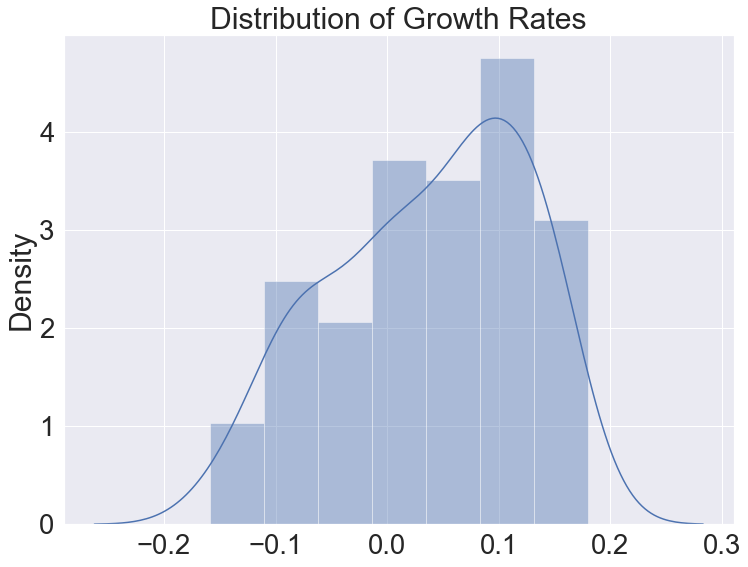

In [46]:
sns.distplot(x)
plt.title("Distribution of Growth Rates")

In [48]:
data_pars = data[data.columns[0:9]]
growth_rate_series = pd.Series(growth_rates)
data_pars["growth_rate"] = growth_rate_series

In [50]:
data_pars

,hazard_rate_scale,infection_reporting_prob,contact_tracing_success_prob,contact_trace_delay_par,global_contact_reduction,two_step_tracing,prob_has_trace_app,0,1,growth_rate
0,0.244234,0.4,0.941355,1.874370,0.289852,False,0.083327,5000,5018,0.063336
1,0.250799,0.5,0.919922,2.494220,0.364649,True,0.137455,5000,5012,0.039467
2,0.231106,0.2,0.740977,1.967681,0.577663,False,0.160811,5000,5008,0.029743
3,0.244234,0.4,0.731077,1.587389,0.263055,True,0.227969,5000,5015,0.090608
4,0.237670,0.3,0.789975,2.014826,0.737690,True,0.359516,5000,5000,-0.065159
...,...,...,...,...,...,...,...,...,...,...
95,0.250799,0.5,0.882274,1.713300,0.132286,False,0.398765,5000,5021,0.087051
96,0.231106,0.2,0.914077,2.495003,0.372532,True,0.451773,5000,5008,0.076501
97,0.224541,0.1,0.806315,1.845686,0.076995,True,0.148336,5000,5021,0.179975
98,0.250799,0.5,0.741664,2.227489,0.045821,False,0.447310,5000,5012,0.142744


                            OLS Regression Results                            
Dep. Variable:            growth_rate   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     2008.
Date:                Wed, 20 Jan 2021   Prob (F-statistic):          3.07e-100
Time:                        11:20:35   Log-Likelihood:                 374.55
No. Observations:                 100   AIC:                            -727.1
Df Residuals:                      89   BIC:                            -698.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

Text(0, 0.5, 'Halving / doubling times (days)')

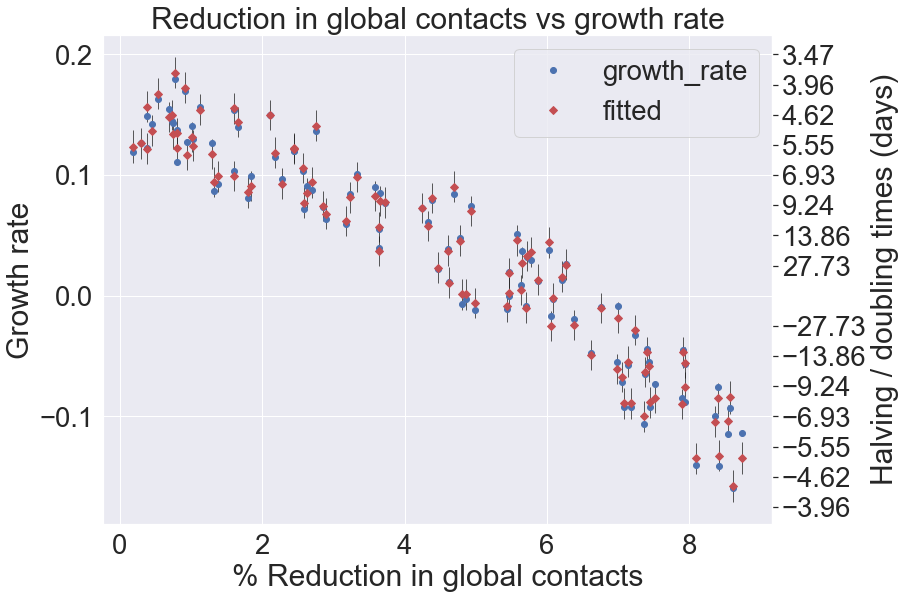

In [56]:
y, X = dmatrices('growth_rate ~ I(global_contact_reduction*10) + I(I(global_contact_reduction*10)**2) + I(I(global_contact_reduction*10)**3) + I(I(global_contact_reduction*10)**4) + I(I(prob_has_trace_app*10)**2) + I(contact_tracing_success_prob*10) + contact_trace_delay_par + I(infection_reporting_prob*10) + I(I(infection_reporting_prob*10)**2) + two_step_tracing', 
                 data = data_pars)
model_2 = sma.OLS(y, X)
res = model_2.fit()
print(res.summary())

fig, ax = plt.subplots()

plot = sm.graphics.regressionplots.plot_fit(res, "I(global_contact_reduction * 10)", ax = ax)

y_vals = np.linspace(-0.175, 0.25, 18)
y_vals = np.concatenate((y_vals[:7], y_vals[8:]))

ax2 = ax.secondary_yaxis("right",
                         functions=(growth_rate_to_doubling_time,
                                    doubling_time_to_growth_rate))
ax2.set_ticks(growth_rate_to_doubling_time(y_vals), minor = False)

plt.xlabel("% Reduction in global contacts")
plt.ylabel("Growth rate")
plt.title("Reduction in global contacts vs growth rate")
ax2.set_ylabel("Halving / doubling times (days)")

In [57]:
res.conf_int(alpha = 0.05)

array([[ 2.70479914e-01,  3.07713676e-01],
       [-9.24616826e-03, -4.15512332e-03],
       [-3.24613287e-02, -1.03960984e-02],
       [-7.29073050e-03,  2.63238586e-03],
       [-3.90929923e-04,  1.27505211e-03],
       [-8.71732650e-05,  5.63467225e-06],
       [-5.30189624e-04, -1.96322253e-04],
       [-1.22028434e-02, -8.97812793e-03],
       [ 1.09638690e-02,  1.94943163e-02],
       [-2.75774639e-02, -1.78408598e-02],
       [ 1.63232330e-04,  1.70838037e-03]])

In [54]:
sns.scatterplot(data_pars["global_contact_reduction"], res.fittedvalues)

ValueError: array length 15 does not match index length 100

## Residuals vs Fitted Value

There doesn't appear to be any systematic deviation from our predicted value

Text(0, 0.5, 'Residual')

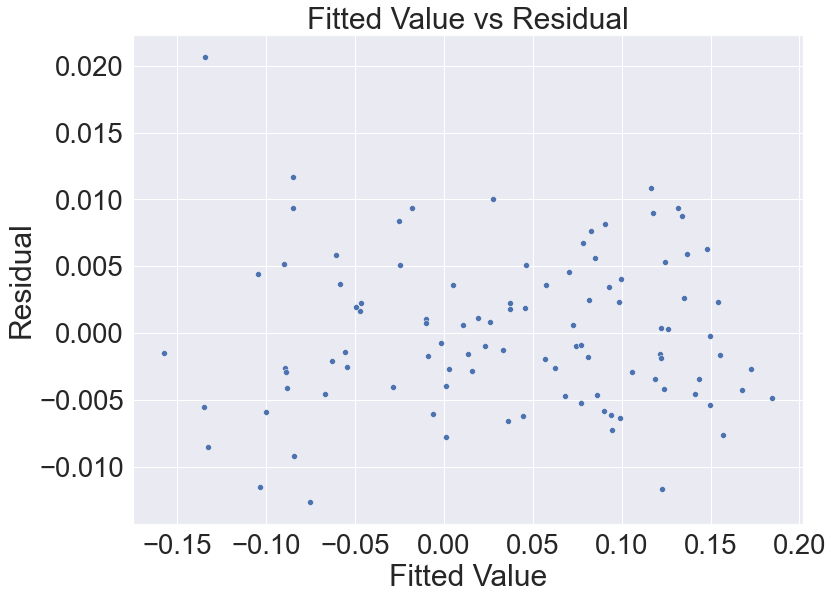

In [65]:
sns.scatterplot(res.fittedvalues, res.resid)
plt.title("Fitted Value vs Residual")
plt.xlabel("Fitted Value")
plt.ylabel("Residual")

## Residual Distribution

Text(0.5, 1.0, 'Distribution of the residuals')

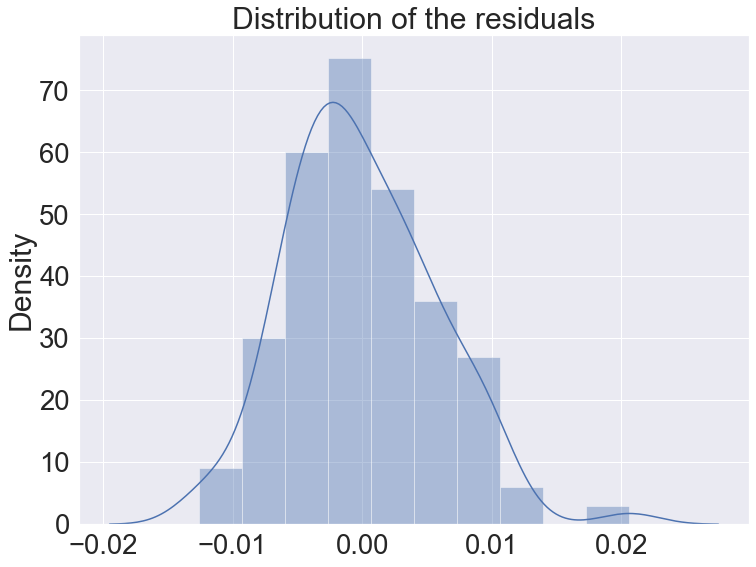

In [66]:
sns.distplot(res.resid)
plt.title("Distribution of the residuals")

Sort of normally distributed

## Comparison to reference distributions

In [67]:
reference_coefs = pd.read_excel("Data/Reference/OLS_coefficients.xlsx", index_col = 0)
reference_coefs

,intercept,coef_contact_reduction,coef_contact_reduction**2,coef_contact_reduction**3,coef_contact_reduction**4
0,0.219887,-0.185921,-0.260727,0.422797,-0.414373


In [68]:
c = reference_coefs["intercept"].loc[0]
beta_0 = reference_coefs["coef_contact_reduction"].loc[0]
beta_1 = reference_coefs["coef_contact_reduction**2"].loc[0]
beta_2 = reference_coefs["coef_contact_reduction**3"].loc[0]
beta_3 = reference_coefs["coef_contact_reduction**4"].loc[0]
x = np.linspace(0, 0.9)
y = c + beta_0*x + beta_1*x**2 + beta_2*x**3 +beta_3*x**4

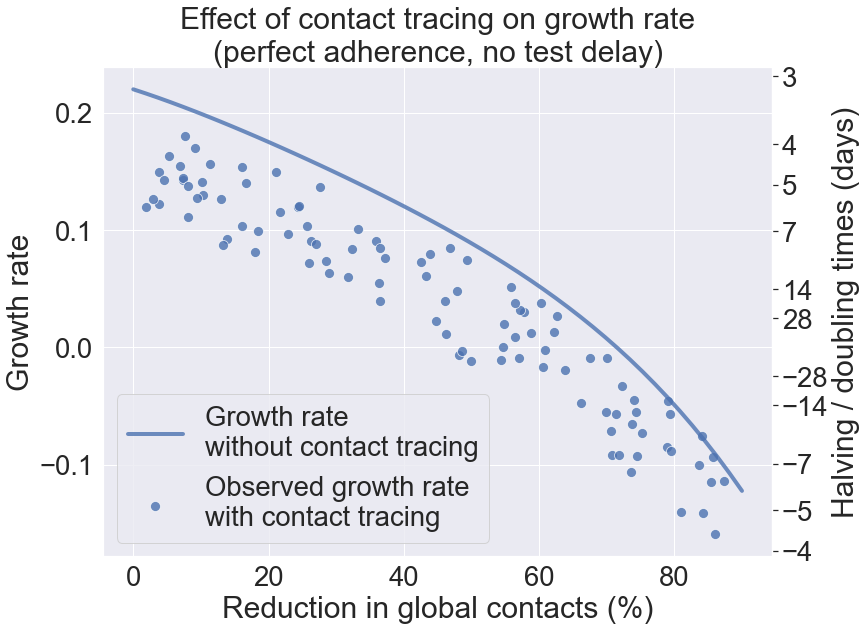

In [72]:

fig, ax = plt.subplots()

sns.scatterplot(data_pars["global_contact_reduction"] * 100, data_pars['growth_rate'], s = 100, alpha = 0.8)
plt.plot(x * 100, y, linewidth = 4, alpha = 0.8)

#y_vals = np.linspace(-0.175, 0.25, 18)
#y_vals = np.concatenate((y_vals[:7], y_vals[8:]))

y_vals = [doubling_time_to_growth_rate(x) for x in [-3, -4, -5, -7, -14, -28, 28, 14, 7, 5, 4, 3]]

ax2 = ax.secondary_yaxis("right",
                         functions=(growth_rate_to_doubling_time,
                                    doubling_time_to_growth_rate))
ax2.set_ticks(growth_rate_to_doubling_time(y_vals), minor = False)


plt.legend(("Growth rate\nwithout contact tracing", "Observed growth rate\nwith contact tracing"))
plt.title("Effect of contact tracing on growth rate\n(perfect adherence, no test delay)")
plt.ylabel("Growth rate")
plt.xlabel("Reduction in global contacts (%)")
ax2.set_ylabel("Halving / doubling times (days)")
plt.savefig("Figures/Simulation - no test delay/growth_rate_comparison.svg", bbox_inches = 'tight')
plt.savefig("Figures/Simulation - no test delay/growth_rate_comparison.png", bbox_inches = 'tight')